# Percepción Computacional
# Evaluación de distintos tipos de algoritmos orientados a la segmentación de imágenes
### Alumnos: Victor Cifuentes, Ivan Calvache, Miguel Murillo, Diego Tamayo

In [1]:
import cv2
import numpy
import math
from PIL import Image
from skimage.filters.thresholding import threshold_otsu
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score, jaccard_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from scipy.ndimage import label

import scipy.ndimage
from skimage.filters import frangi
from skimage import data, img_as_float
from skimage.io import imread
from skimage.segmentation import (morphological_chan_vese, morphological_geodesic_active_contour, inverse_gaussian_gradient, checkerboard_level_set)

## Algoritmo de Otsu

In [2]:
def algoritmo_otsu(directorio_imagen: str, directorio_imagen_procesadas: str):
    # Abrimos la imagen y la convertimos a escala de grises
    a = Image.open(directorio_imagen + "imagen_1.png").convert('L')
    a = numpy.asarray(a)

    # Píxeles con intensidad mayor que la umbral se mantienen
    thresh = threshold_otsu(a)
    b = 255*(a > thresh)

    # Escribimos la imagen
    cv2.imwrite(directorio_imagen_procesadas+'otsu.png', b)

    a50 = cv2.imread(directorio_imagen_procesadas+"otsu.png")
    aGT = cv2.imread(directorio_imagen + "imagen_1_wgt1.png")
    a52 = cv2.imread(directorio_imagen + "imagen_1.png")

    # Manejo de los graficos
    plt.figure(figsize=(20, 20))
    plt.subplot(131), plt.imshow(cv2.cvtColor(
        a52, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(cv2.cvtColor(
        a50, cv2.COLOR_BGR2RGB)), plt.title('Segmentada Otsu')
    plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(cv2.cvtColor(
        aGT, cv2.COLOR_BGR2RGB)), plt.title('GroundTruth')
    plt.xticks([]), plt.yticks([])
    plt.show()

    # Convertimos la imagen en una lista de elementos 255, 0
    segmentada_otsu = a50.reshape(-1)
    groundTruth = aGT.reshape(-1)

    mse = mean_squared_error(groundTruth, segmentada_otsu, squared=False)
    f1 = f1_score(groundTruth, segmentada_otsu, average='macro')
    rmse = math.sqrt(mse)

    img_true = groundTruth.ravel()
    img_pred = segmentada_otsu.ravel()
    iou = jaccard_score(img_true, img_pred, average='macro')

    cm = confusion_matrix(groundTruth, segmentada_otsu)
    classification_rep = classification_report(groundTruth, segmentada_otsu)
    
    print('RMSE: {}'.format(rmse))
    print('F1-SCORE: {}'.format(f1))
    print('JACCARD SCORE: {}'.format(iou))
    print('MATRIZ DE CONFUSION:  \n{}'.format(cm))
    print('CLASSIFICATION REPORT:  \n{}'.format(classification_rep))

    return groundTruth

## Aplicación de Segmentación por Umbral adaptativo (Adaptive Thresholding)


In [3]:
def algoritmo_adaptive_thresholding(directorio_imagen: str, directorio_imagen_procesadas: str):
    # Abrimos la imagen  y la convertimos a escala de grises
    a = Image.open(directorio_imagen + 'imagen_1.png').convert('L')

    # Se establece un umbral para el algoritmo
    a = numpy.asarray(a)  
    b = cv2.adaptiveThreshold(a, a.max(), cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 1)

    # Escribir imagen resultante
    cv2.imwrite(directorio_imagen_procesadas + '_adaptive_thresholding.png', b)

    # Cargamos las tres imagenes Original, Segmentada , y la esperada
    a40 = cv2.imread(directorio_imagen_procesadas + "_adaptive_thresholding.png")
    aGT = cv2.imread(directorio_imagen + "imagen_1_wgt1.png")
    a42 = cv2.imread(directorio_imagen + "imagen_1.png")

    groundTruth = aGT.reshape(-1)

    # Visualizacion de Graficos
    plt.figure(figsize=(20, 20))
    plt.subplot(131), plt.imshow(cv2.cvtColor(
        a42, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(cv2.cvtColor(a40, cv2.COLOR_BGR2RGB)
                                 ), plt.title('Segmentada Umbral Adaptativo')
    plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(cv2.cvtColor(
        aGT, cv2.COLOR_BGR2RGB)), plt.title('GroundTruth')
    plt.xticks([]), plt.yticks([])
    plt.show()

    # Obtencion de metricas
    # Convertimos la imagen en una lista de elementos 255, 0
    segmentada_adaptive_threshold = a40.reshape(-1)

    mse = mean_squared_error(
        groundTruth, segmentada_adaptive_threshold, squared=False)
    f1 = f1_score(groundTruth, segmentada_adaptive_threshold, average='macro')

    rmse = math.sqrt(mse)

    img_true = groundTruth.ravel()
    img_pred = segmentada_adaptive_threshold.ravel()
    iou = jaccard_score(img_true, img_pred, average='macro')

    cm = confusion_matrix(groundTruth, segmentada_adaptive_threshold)
    classification_rep = classification_report(
        groundTruth, segmentada_adaptive_threshold)

    print('RMSE: {}'.format(rmse))
    print('F1-SCORE: {}'.format(f1))
    print('JACCARD SCORE: {}'.format(iou))
    print('MATRIZ DE CONFUSION:  \n{}'.format(cm))
    print('CLASSIFICATION REPORT:  \n{}'.format(classification_rep))


## Aplicación Algortimo WaterShed

In [4]:
def algoritmo_watershed(directorio_imagen: str, directorio_imagen_procesadas: str):
    img_original = cv2.imread(directorio_imagen + 'imagen_1.png')
    gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
    thresh, b1 = cv2.threshold(gray, 0, 255,  cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    b2 = cv2.erode(b1, None, iterations=2)
    dist_trans = cv2.distanceTransform(b2, 2, 3)
    thresh, dt = cv2.threshold(dist_trans, 1,  255, cv2.THRESH_BINARY)
    labelled, ncc = label(dt)
    cv2.watershed(img_original, labelled)

    # Escribir imagenes
    cv2.imwrite(directorio_imagen_procesadas + 'watershed.png', labelled)
    
    # Lectura Imagen
    segm_water = cv2.imread(directorio_imagen_procesadas + 'watershed.png')
    
    # Binarizacion
    ret, thresh1 = cv2.threshold(segm_water, 40, 255, cv2.THRESH_BINARY)

    # Lectura imagen de ground truth
    img_gt = cv2.imread(directorio_imagen + "imagen_1_wgt1.png")
    y_true = img_gt.ravel()
    y_pred = thresh1.ravel()

    # manejo de las graficas
    # plt.axis("off")
    plt.figure(figsize=(20, 20))
    plt.subplot(131), plt.imshow(cv2.cvtColor(
        img_original, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(cv2.cvtColor(
        segm_water, cv2.COLOR_BGR2RGB)), plt.title('WaterShed Umbral Adaptativo')
    plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(cv2.cvtColor(
        img_gt, cv2.COLOR_BGR2RGB)), plt.title('GroundTruth')
    plt.xticks([]), plt.yticks([])
    plt.show()

    # Cálculo de métricas
    mse = mean_squared_error(y_true, y_pred, squared=False)
    f1 = f1_score(y_true, y_pred, average='macro')
    rmse = math.sqrt(mse)
    iou = jaccard_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred)

    print('RMSE: {}'.format(rmse))
    print('F1-SCORE: {}'.format(f1))
    print('JACCARD SCORE: {}'.format(iou))
    print('MATRIZ DE CONFUSION:  \n{}'.format(cm))
    print('CLASSIFICATION REPORT:  \n{}'.format(classification_rep))

    return y_pred


## Ejecucion de algoritmos

In [5]:
directorio_imagen = "img/"
directorio_imagen_procesadas = "procesadas/"

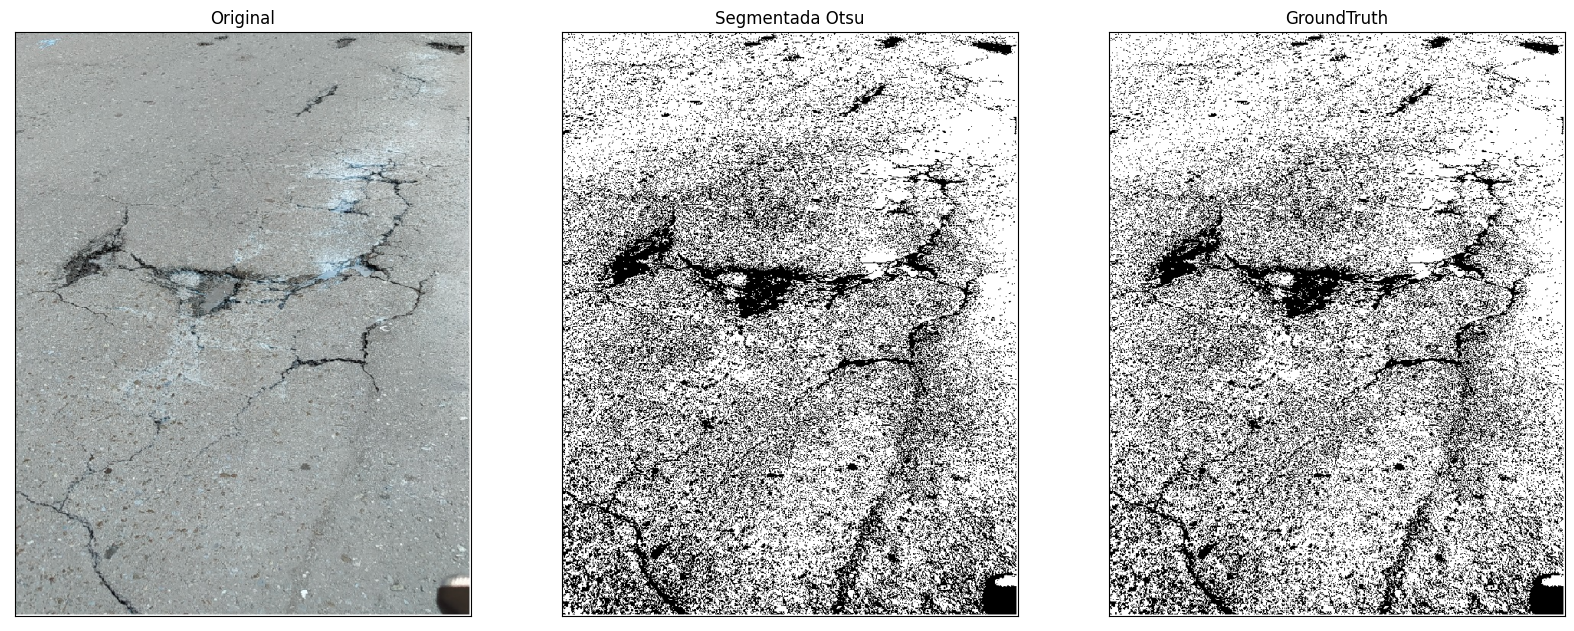

RMSE: 0.41326442348034115
F1-SCORE: 0.9655505471335675
JACCARD SCORE: 0.9337243422106895
MATRIZ DE CONFUSION:  
[[394488      3]
 [ 39723 927741]]
CLASSIFICATION REPORT:  
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    394491
         255       1.00      0.96      0.98    967464

    accuracy                           0.97   1361955
   macro avg       0.95      0.98      0.97   1361955
weighted avg       0.97      0.97      0.97   1361955



In [6]:
groundTruth = algoritmo_otsu(directorio_imagen, directorio_imagen_procesadas)


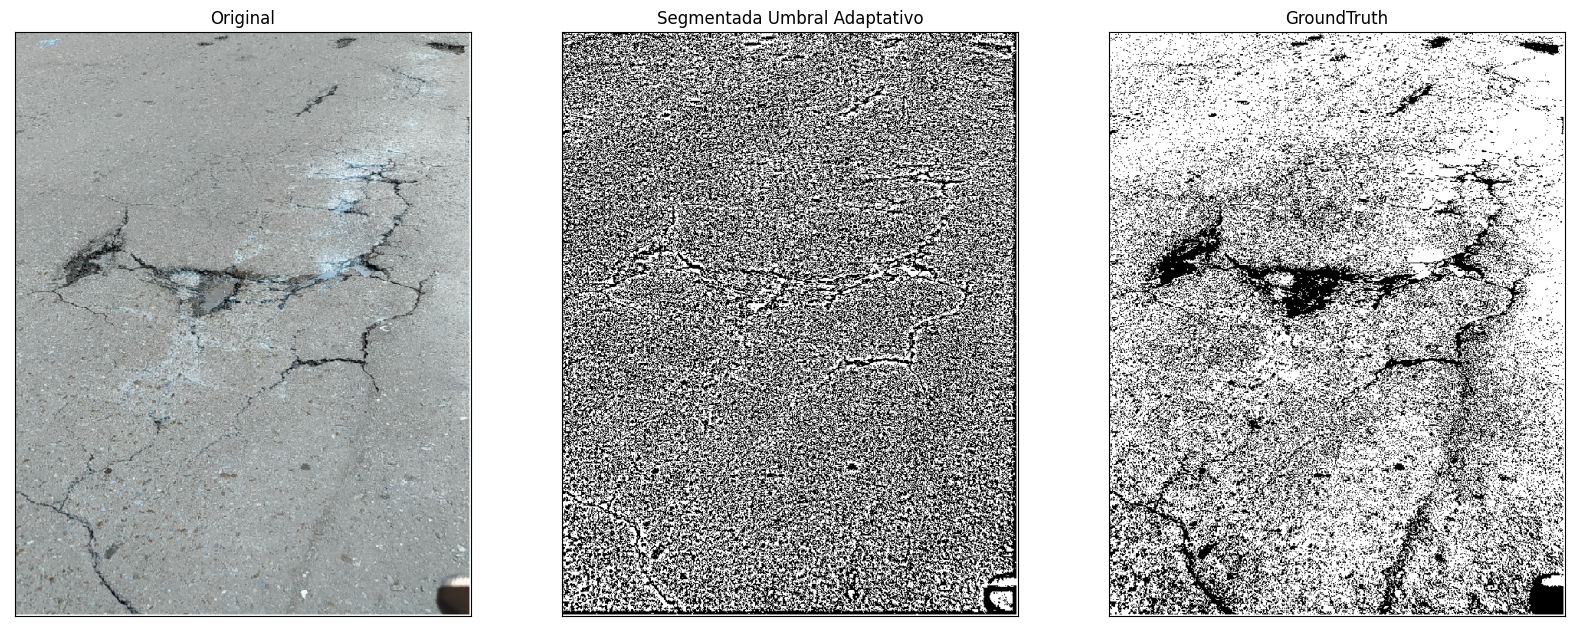

RMSE: 0.6939318340968819
F1-SCORE: 0.7551720861269615
JACCARD SCORE: 0.6099406965102816
MATRIZ DE CONFUSION:  
[[366480  28011]
 [287802 679662]]
CLASSIFICATION REPORT:  
              precision    recall  f1-score   support

           0       0.56      0.93      0.70    394491
         255       0.96      0.70      0.81    967464

    accuracy                           0.77   1361955
   macro avg       0.76      0.82      0.76   1361955
weighted avg       0.84      0.77      0.78   1361955



In [7]:
algoritmo_adaptive_thresholding(directorio_imagen, directorio_imagen_procesadas)

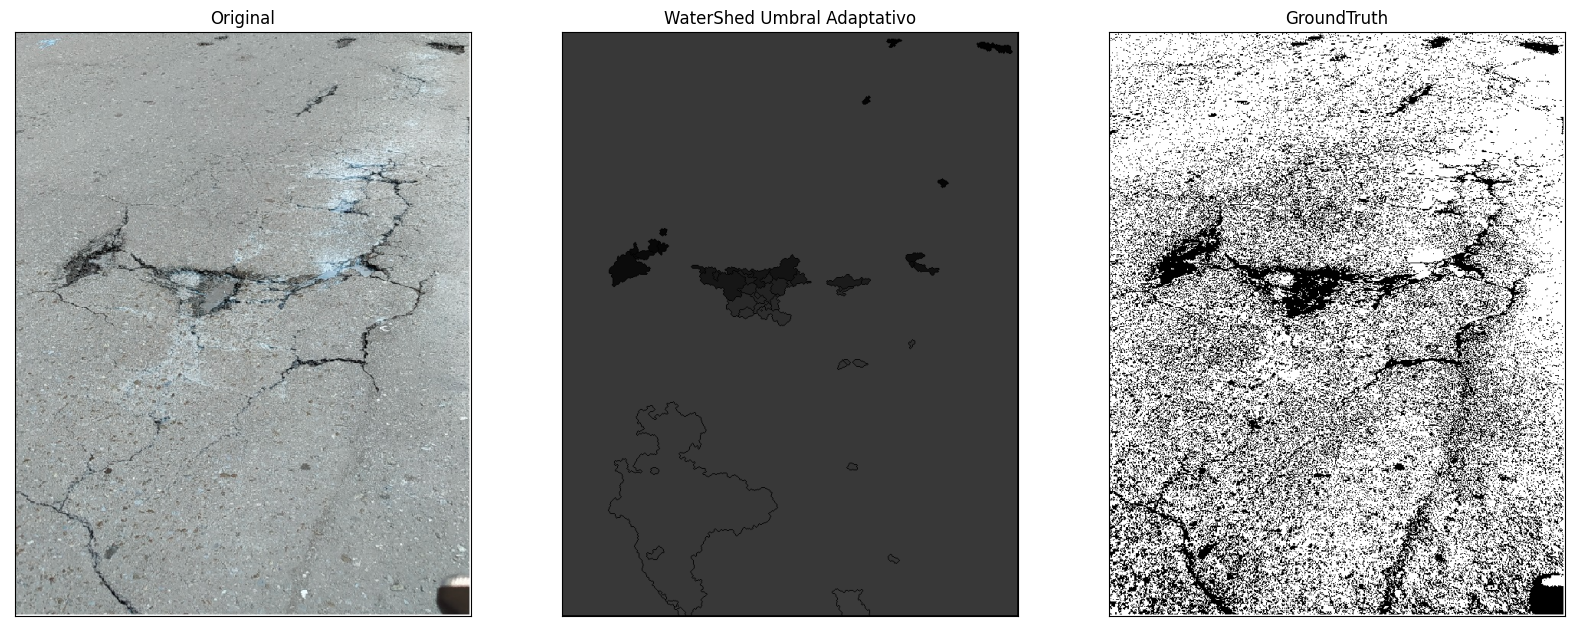

RMSE: 0.7279133681123416
F1-SCORE: 0.4770521196508761
JACCARD SCORE: 0.3890991194484872
MATRIZ DE CONFUSION:  
[[ 26358 368133]
 [ 14235 953229]]
CLASSIFICATION REPORT:  
              precision    recall  f1-score   support

           0       0.65      0.07      0.12    394491
         255       0.72      0.99      0.83    967464

    accuracy                           0.72   1361955
   macro avg       0.69      0.53      0.48   1361955
weighted avg       0.70      0.72      0.63   1361955



In [8]:
y_pred = algoritmo_watershed(directorio_imagen, directorio_imagen_procesadas)

## Aplicación de Segmentación por votación

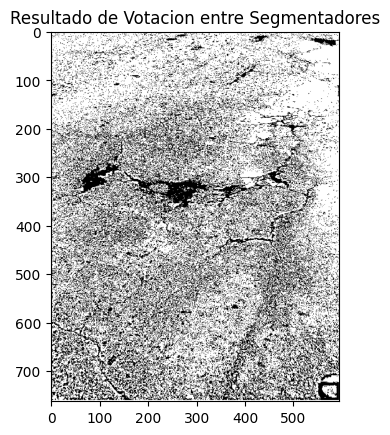

F1-SCORE: 0.9511183195861536
JACCARD SCORE: 0.9074865954038824
MATRIZ DE CONFUSION:  
[[374583  19908]
 [ 35517 931947]]
CLASSIFICATION REPORT:  
              precision    recall  f1-score   support

           0       0.91      0.95      0.93    394491
         255       0.98      0.96      0.97    967464

    accuracy                           0.96   1361955
   macro avg       0.95      0.96      0.95   1361955
weighted avg       0.96      0.96      0.96   1361955



In [9]:
i = 0
resp = []
img_original = cv2.imread(directorio_imagen + 'imagen_1.png')

a50 = cv2.imread(directorio_imagen_procesadas + "otsu.png")
segmentada_otsu = a50.reshape(-1)

a40 = cv2.imread(directorio_imagen_procesadas + "_adaptive_thresholding.png")
segmentada_adaptive_threshold =a40.reshape(-1)

while i < len(segmentada_otsu):
    tot = int(segmentada_otsu[i]) + \
        int(segmentada_adaptive_threshold[i]) + int(y_pred[i])
    if tot > 382.5:
        resp.append(255)
    else:
        resp.append(0)
    i += 1

resp = numpy.array(resp)

imgResp = numpy.array(resp).reshape(img_original.shape)
plt.imshow(imgResp)
plt.title("Resultado de Votacion entre Segmentadores")
plt.show()


f1 = f1_score(groundTruth, resp, average='macro')

iou = jaccard_score(groundTruth, resp, average='macro')
cm = confusion_matrix(groundTruth, resp)
classification_rep = classification_report(groundTruth, resp)

print('F1-SCORE: {}'.format(f1))
print('JACCARD SCORE: {}'.format(iou))
print('MATRIZ DE CONFUSION:  \n{}'.format(cm))
print('CLASSIFICATION REPORT:  \n{}'.format(classification_rep))
